Prathmesh Kulkarni

Importing Libraries

In [2]:
import numpy as np
import cv2
import os
import random
from skimage.io import imread
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, Conv2D, MaxPool2D, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
import matplotlib.pyplot as plt
from IPython.display import Audio

In [11]:
print("TensorFlow version :", tf.__version__)
print("Num GPUs Available:", len(tf.config.experimental.list_physical_devices('GPU')))

TensorFlow version : 2.12.0
Num GPUs Available: 0


Importing Datasets

In [12]:
train_dir = r'/content/train'
test_dir = r'/content/test'

row, col = 48,48
classes = 7

def count_exp(path, set_):
  dict_ = {}
  for expression in os.listdir(path):
    dir_ = path +"/" + expression
    dict_[expression] = len(os.listdir(dir_))
    df = pd.DataFrame(dict_, index =[set_])
    return df
train_count = count_exp(train_dir, 'train')
test_count = count_exp(test_dir, 'test')
print(train_count)
print(test_count)

       neutral
train     4965
      neutral
test     1233


Data Visualization

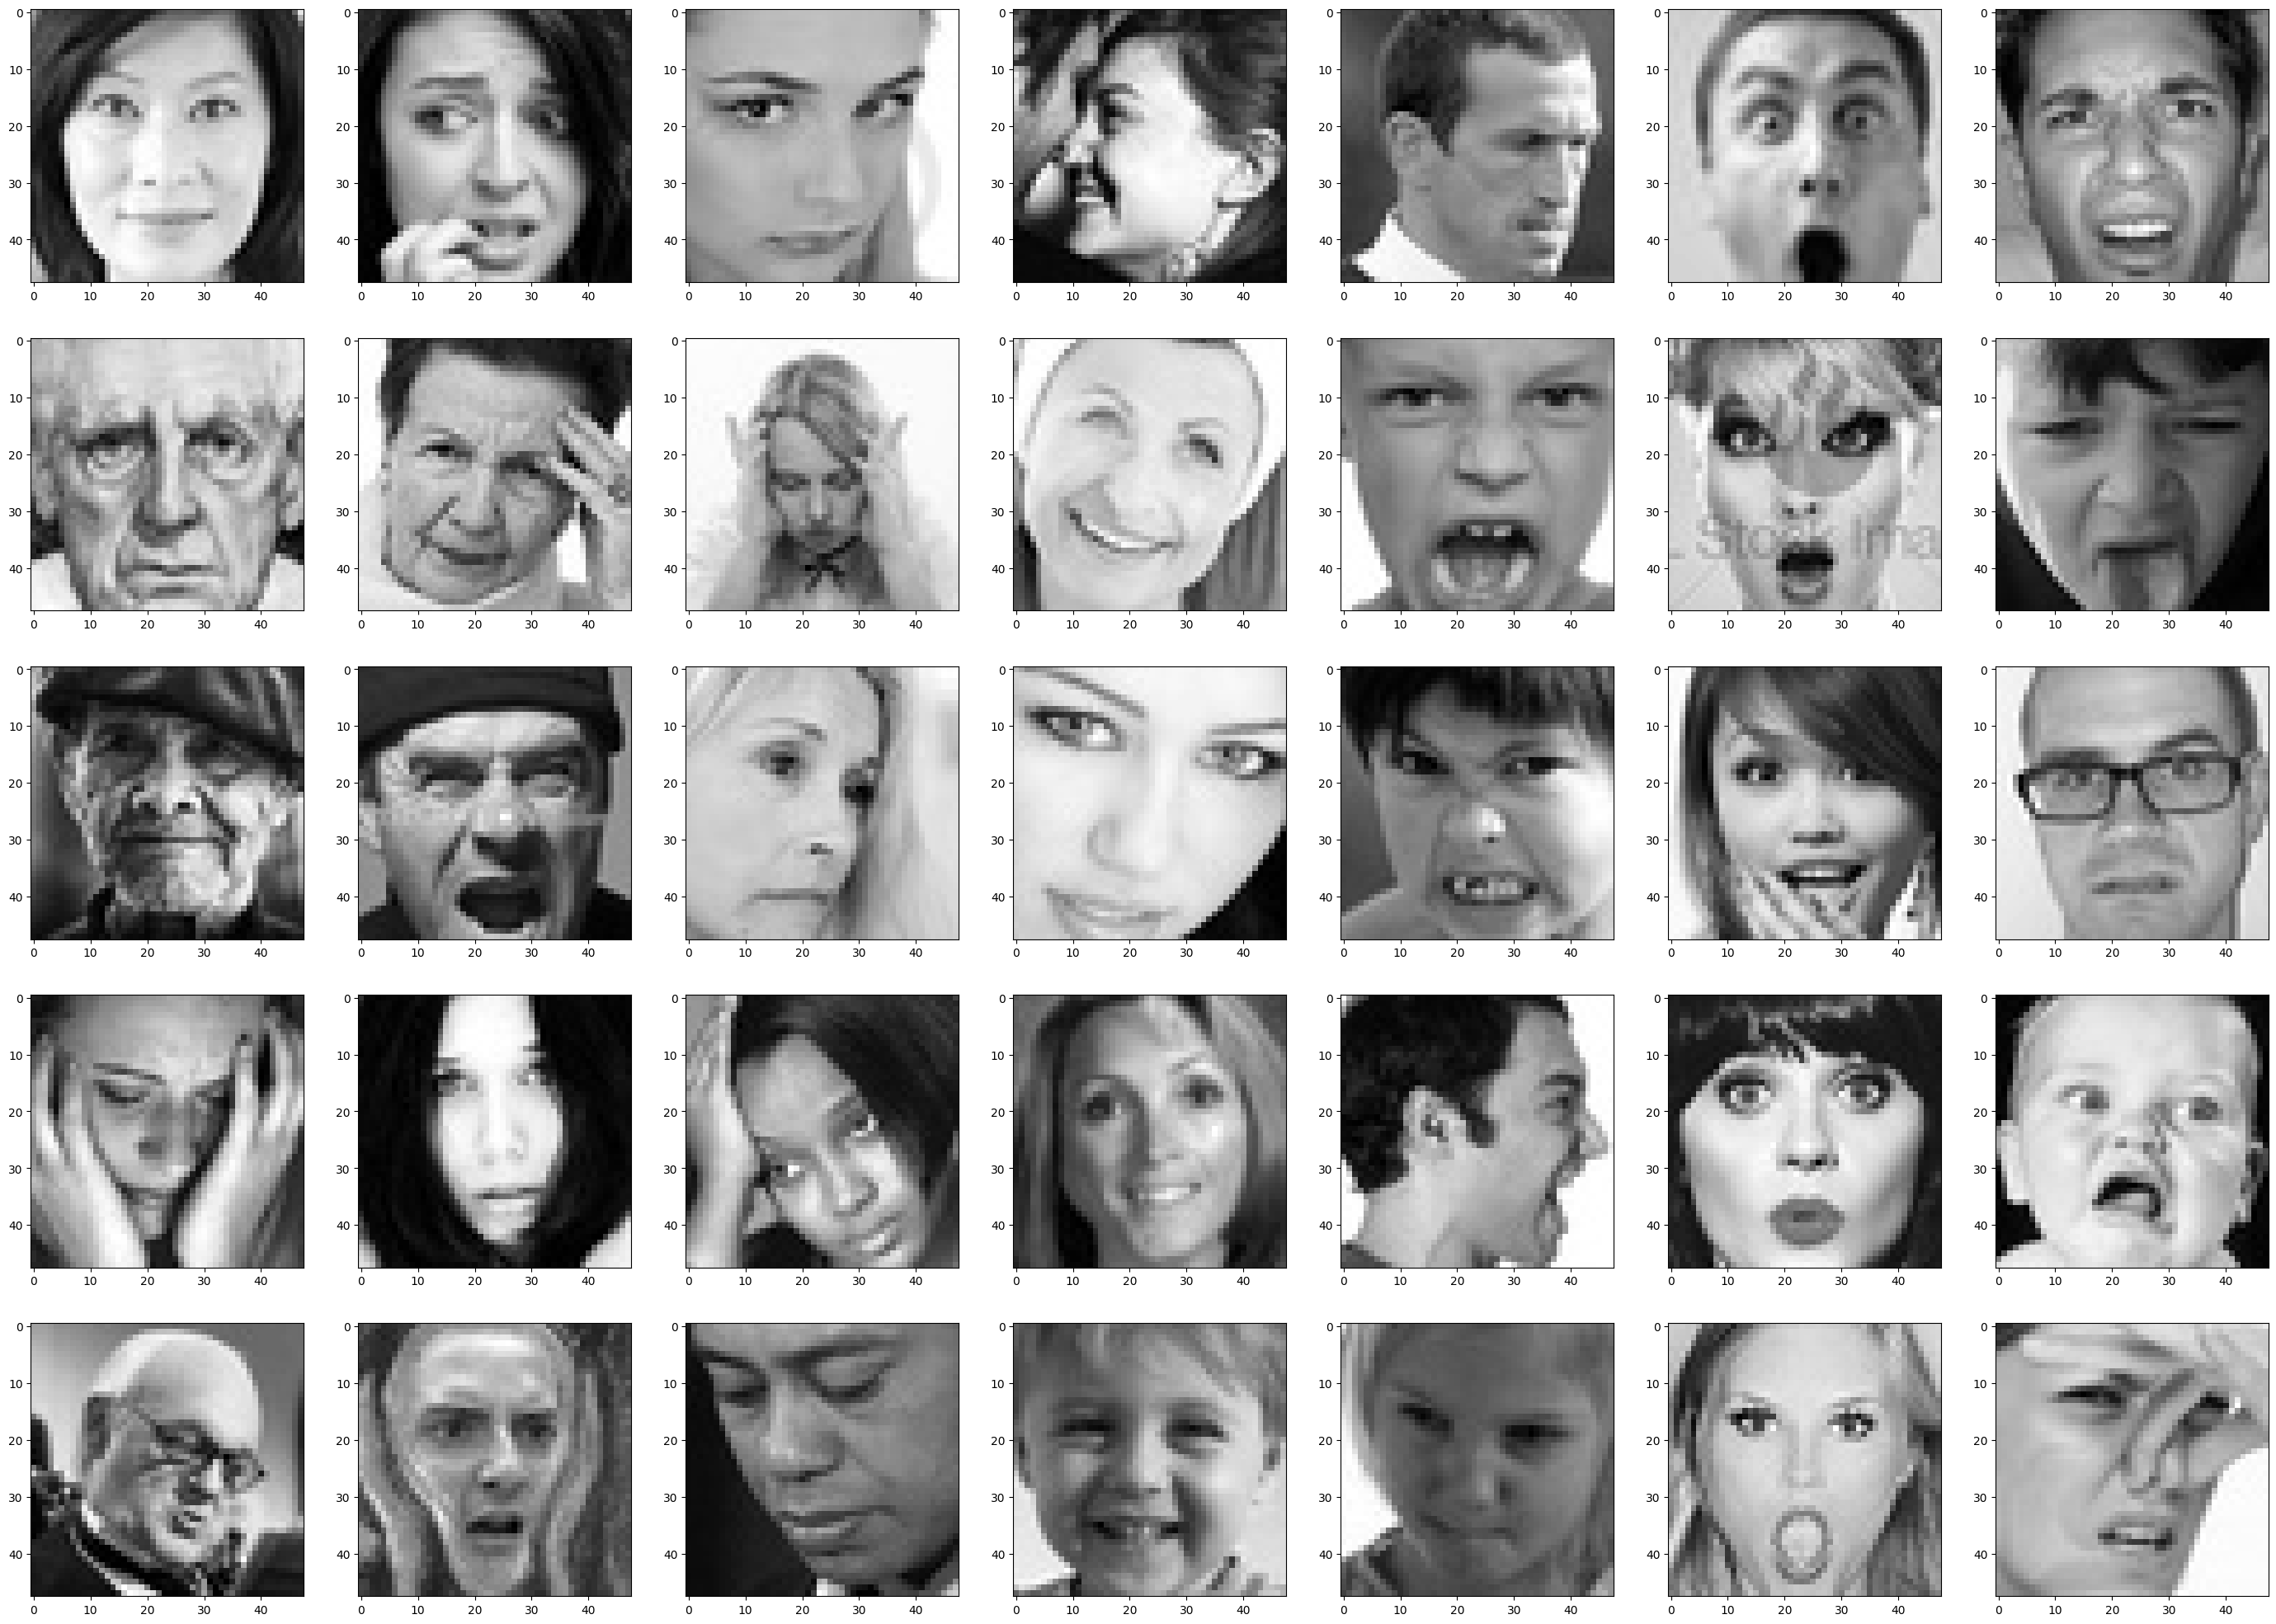

In [13]:
from skimage.io import imread
train_dir = ("/content/train/")
test_dir = ("/content/test/")
total_labels = len(os.listdir(train_dir))

fig, ax = plt.subplots(nrows = 5, ncols = total_labels, figsize =(35,25))
for x in range(5):
  for y,v in zip(range(total_labels),os.listdir(train_dir)):
    ax[x][y].imshow(imread(train_dir+v+'/'+os.listdir(train_dir+v)[x]),cmap = 'gray')
plt.show()

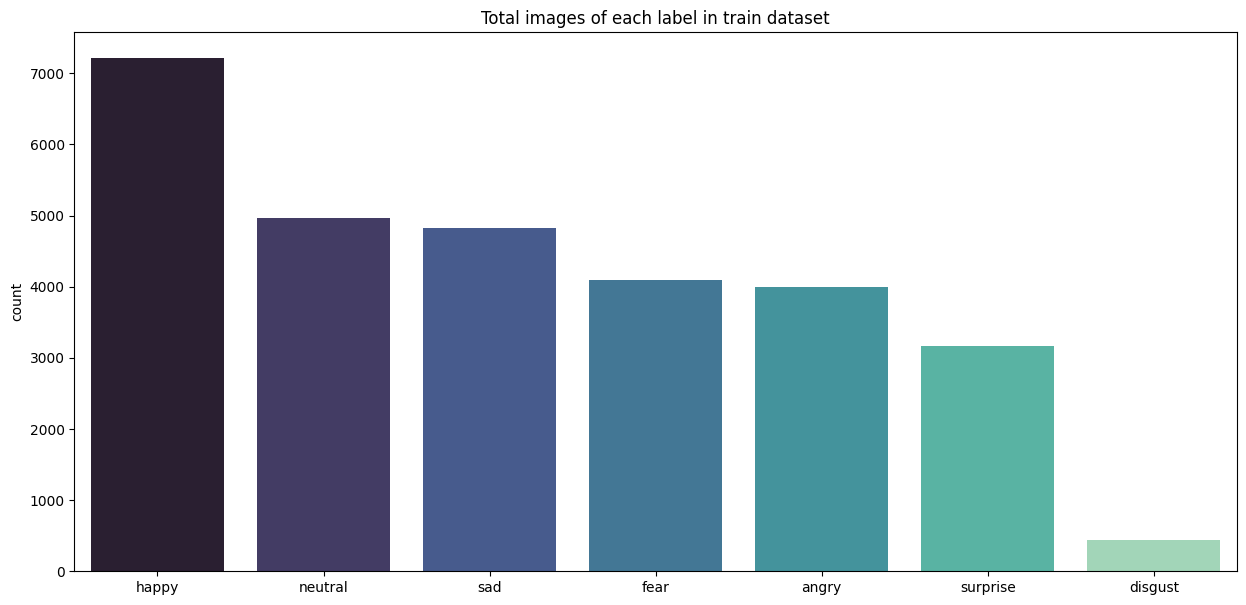

In [40]:
df = {}
for i in os.listdir(train_dir):
  directory = train_dir + i
  df[i] = len(os.listdir(directory))
df = pd.DataFrame(df,index=["total"]).transpose().sort_values("total",ascending=False)

plt.figure(figsize =(15,7))
sns.barplot(x=df.index, y="total", palette="mako", data=df)
plt.ylabel("count")
plt.title("Total images of each label in train dataset")
plt.show()

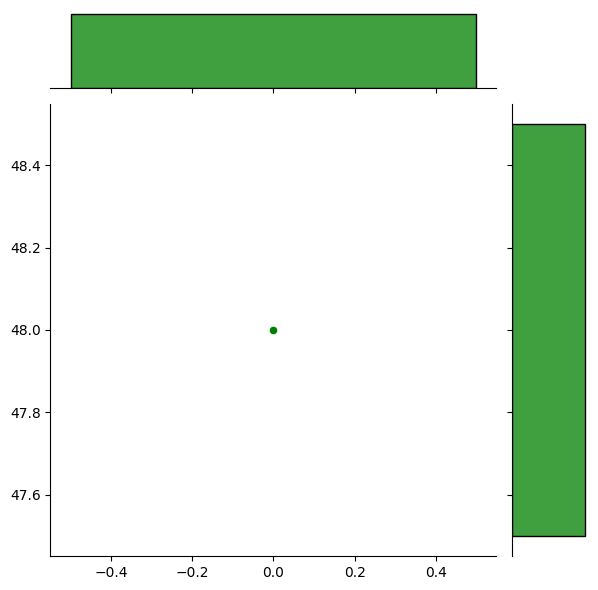

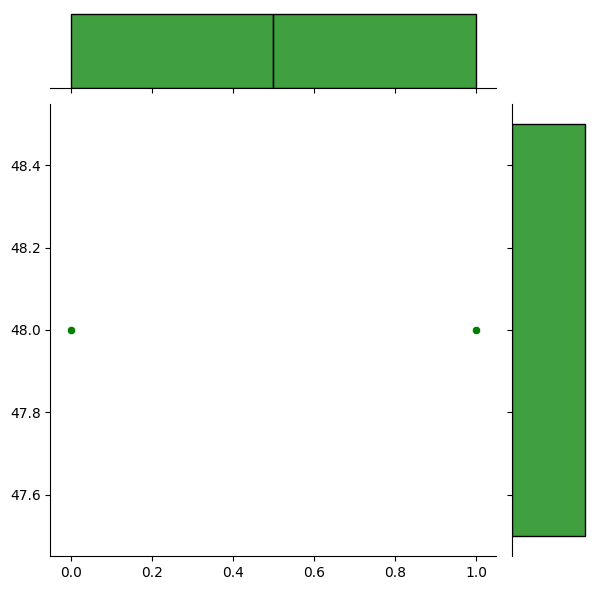

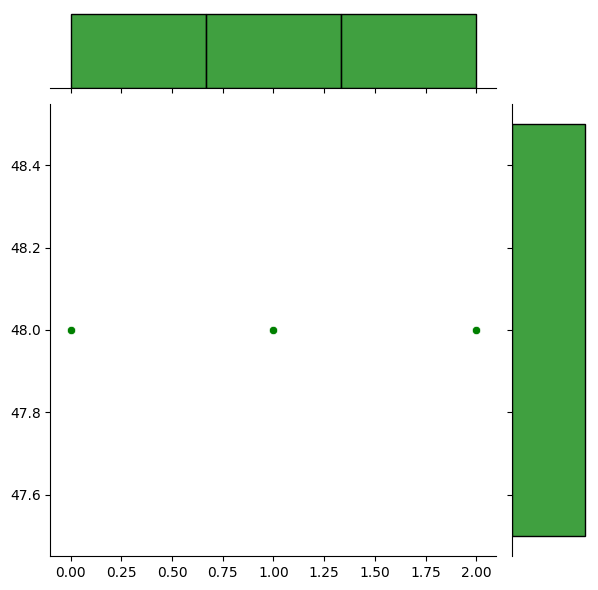

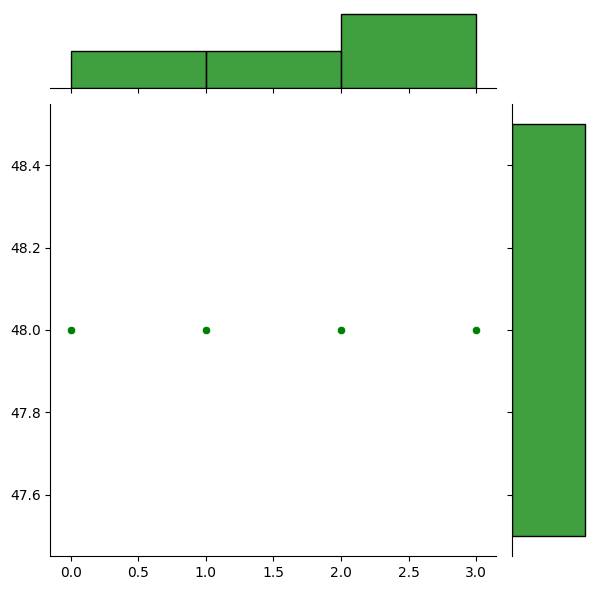

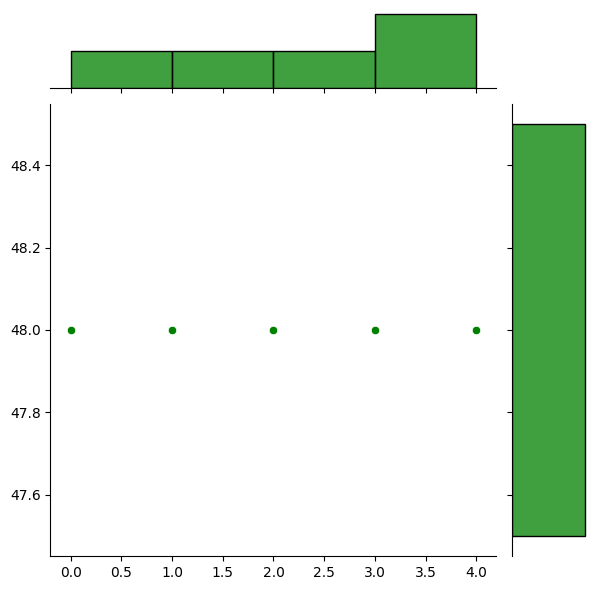

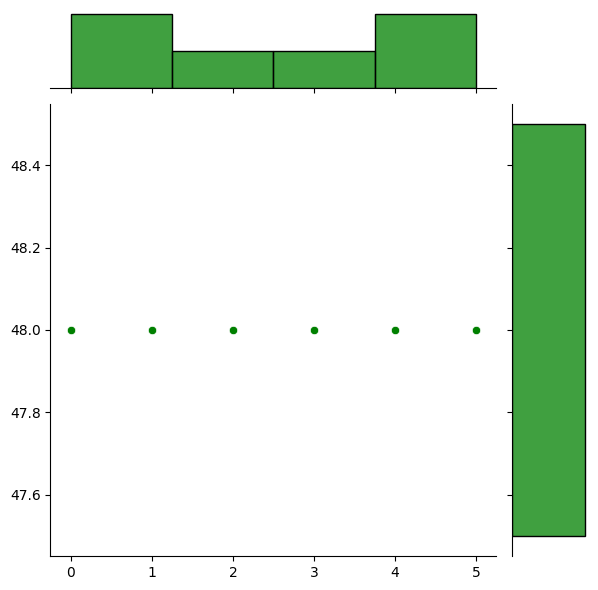

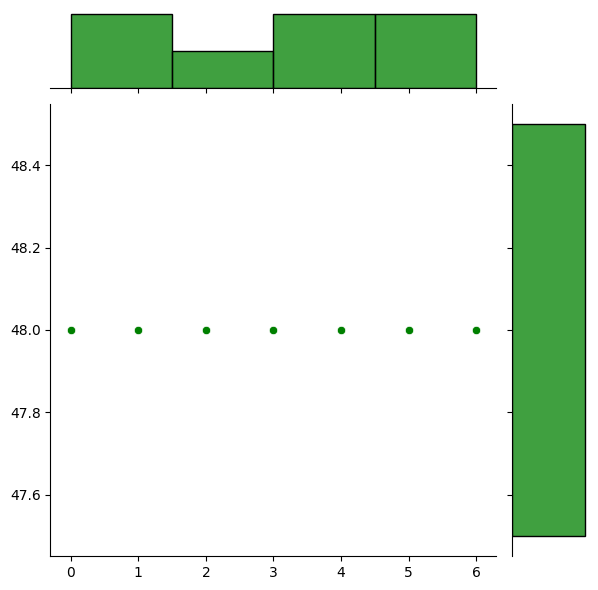

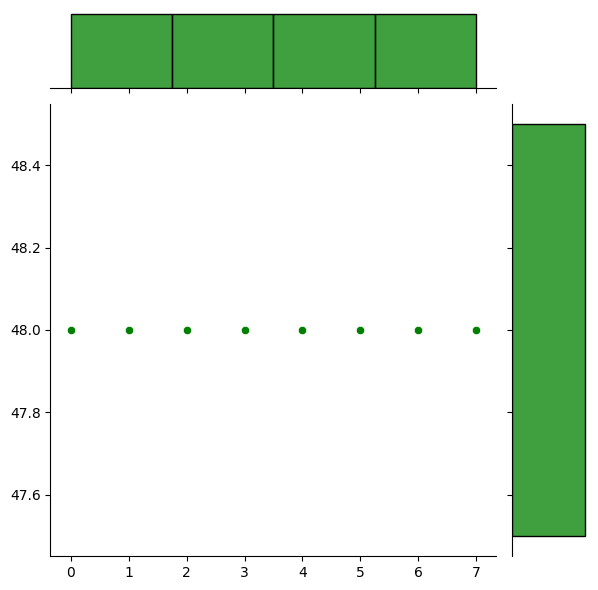

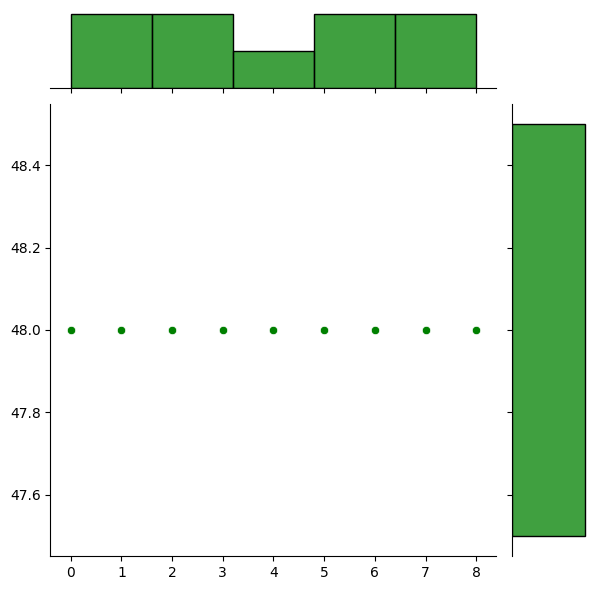

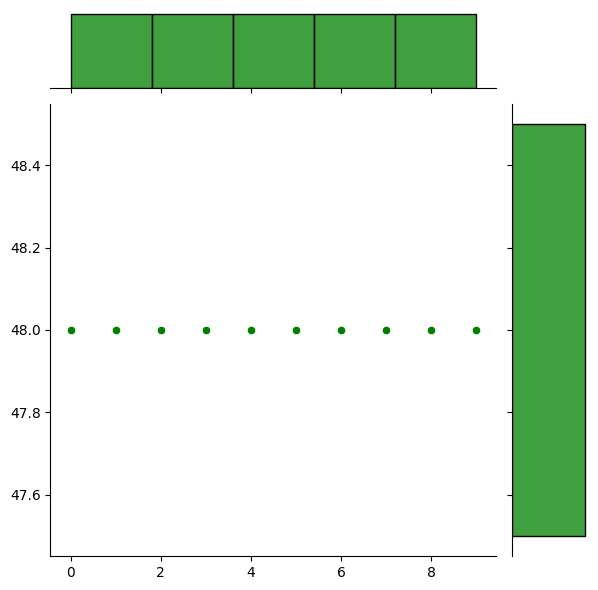

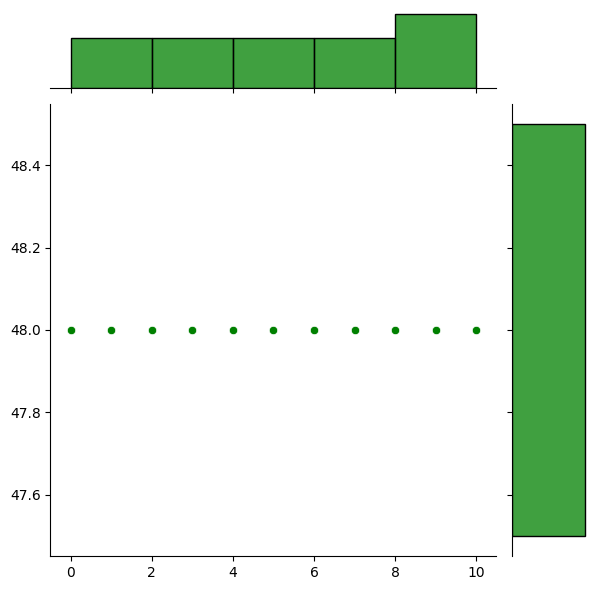

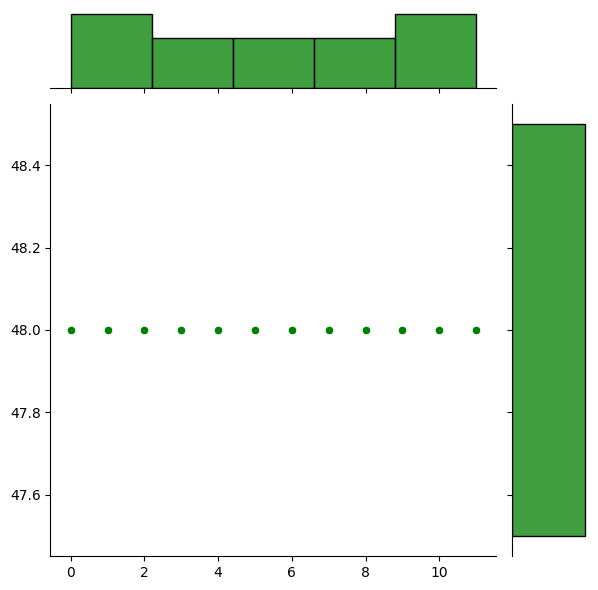

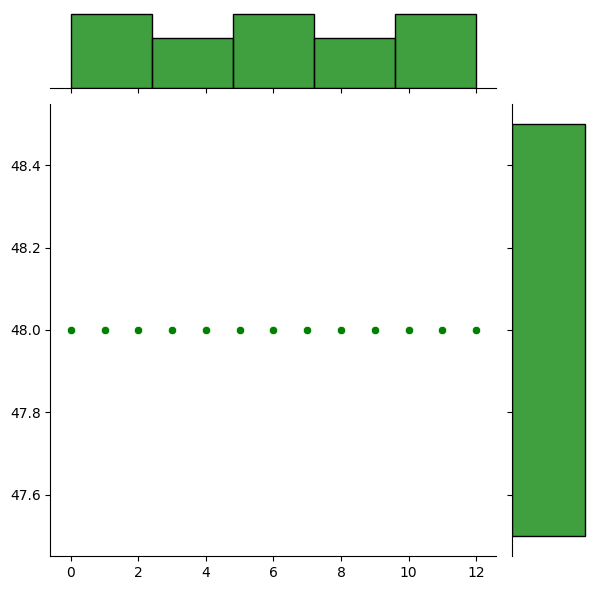

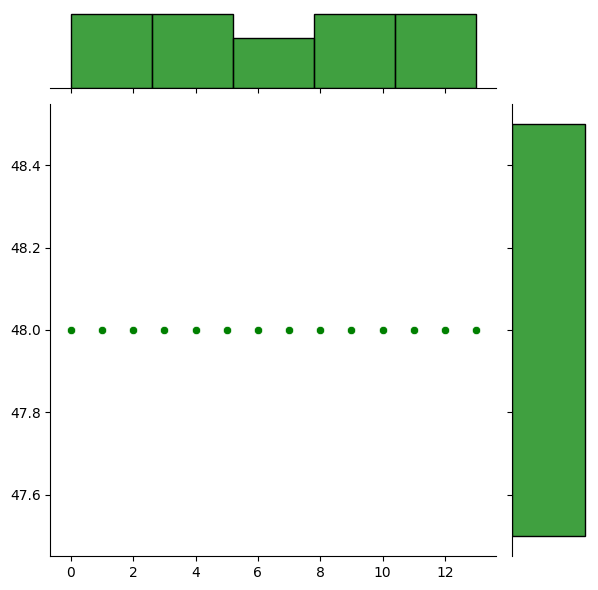

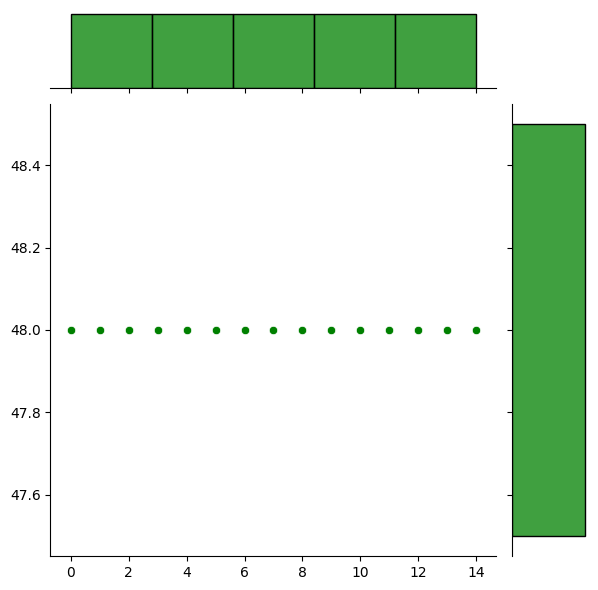

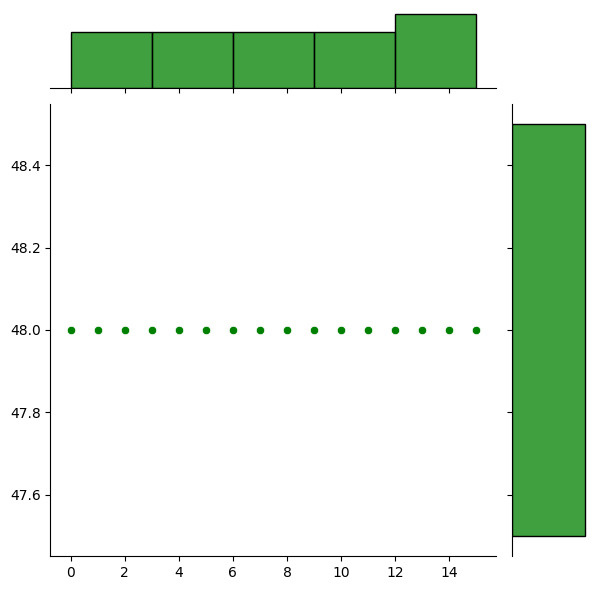

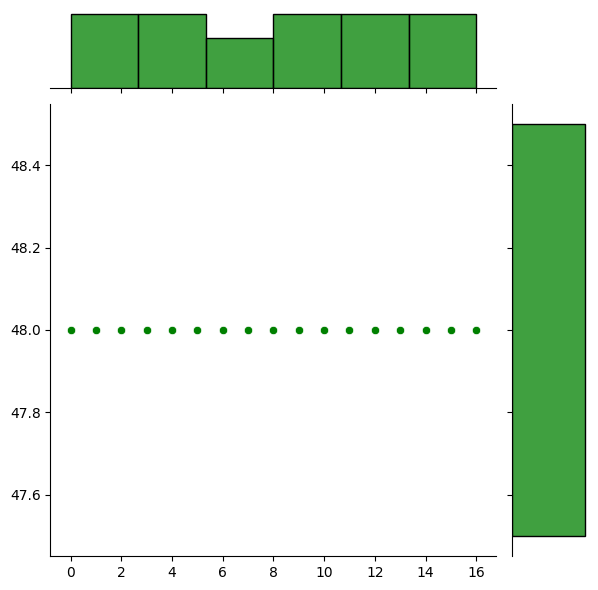

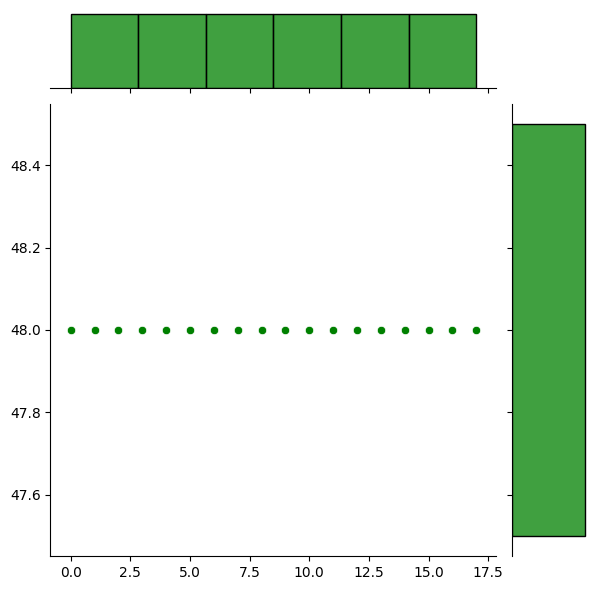

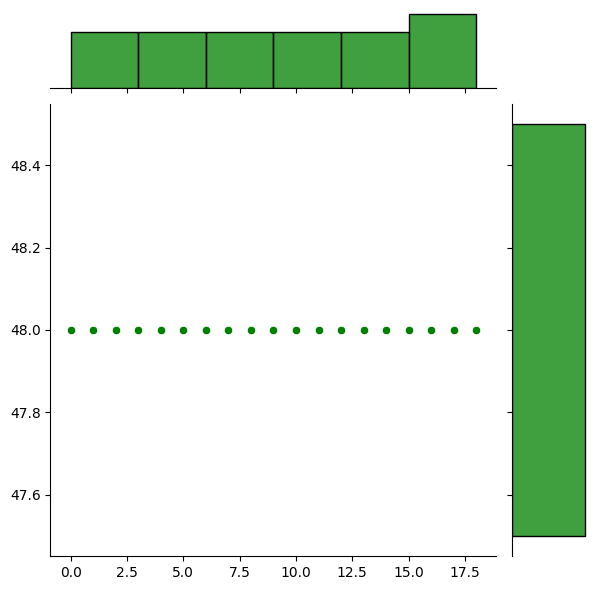

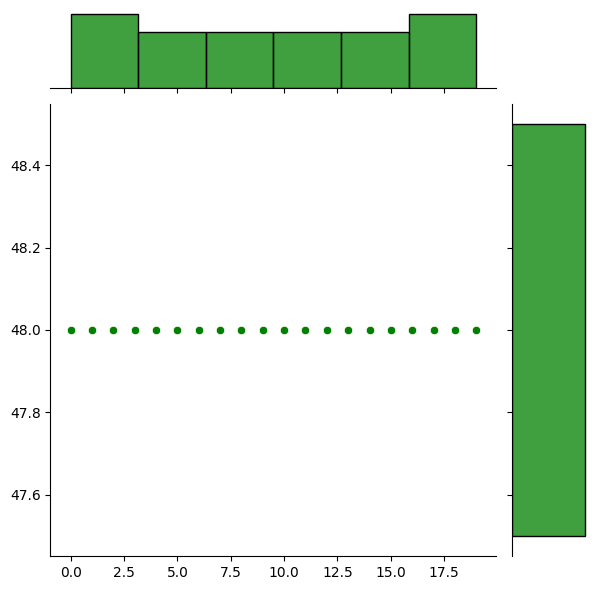

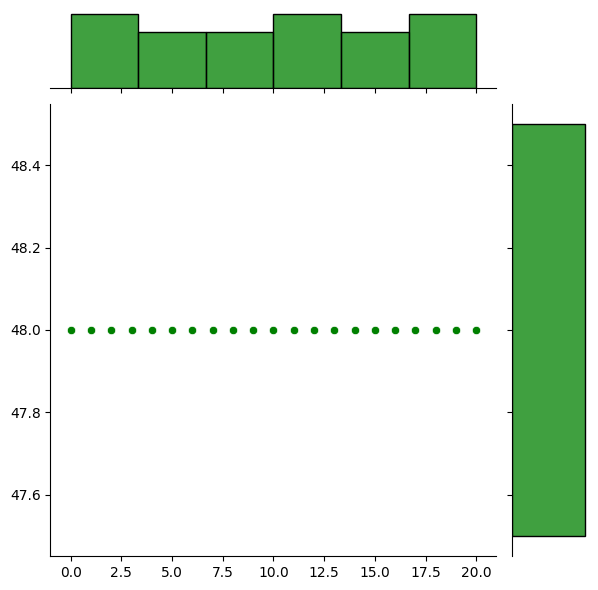

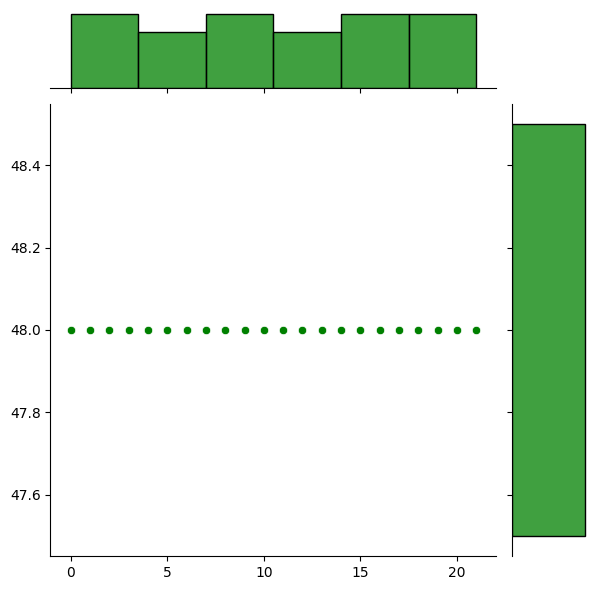

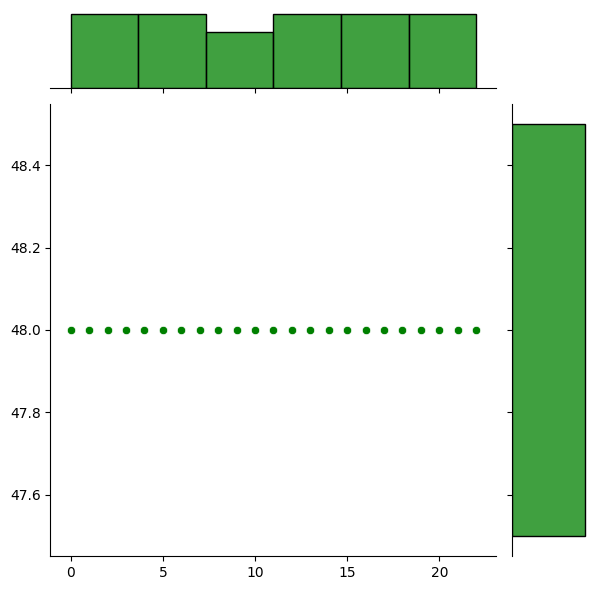

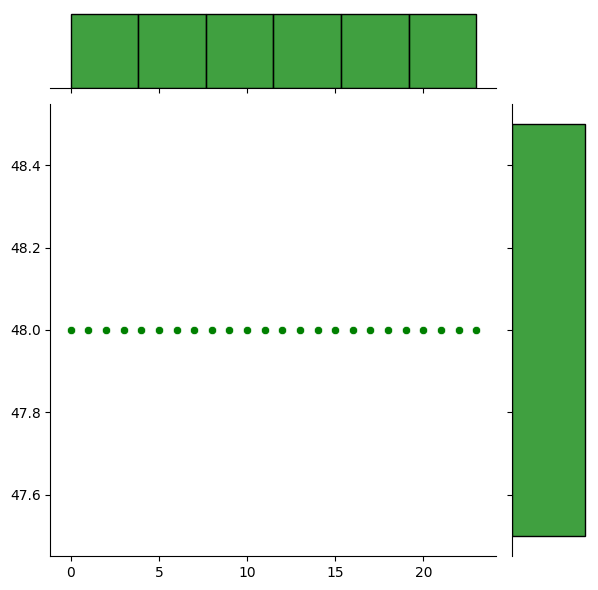

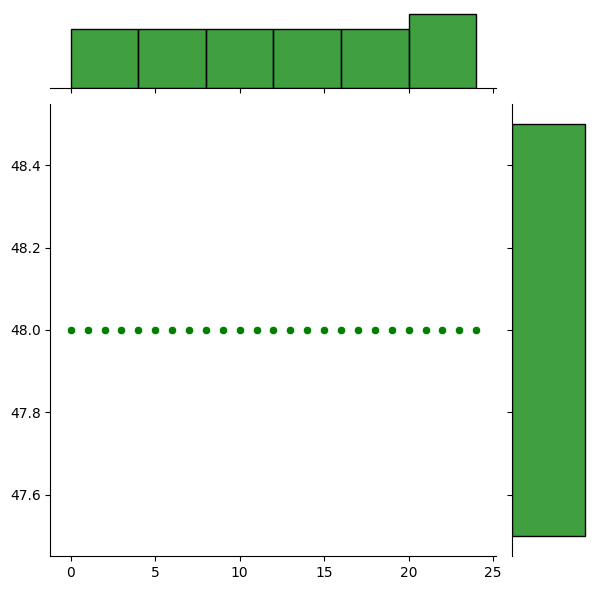

KeyboardInterrupt: ignored

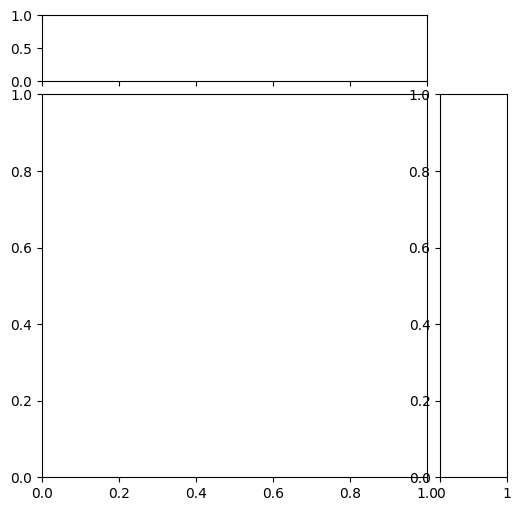

In [41]:
happy = os.listdir(train_dir +'happy/')
dim1, dim2 = [] ,[]
for img_filename in happy:
  img = imread(train_dir +'happy/'+img_filename)
  d1, d2 = img.shape
  dim1.append(d1)
  dim2.append(d2)

  img_shape = (int(np.mean(dim1)), int(np.mean(dim2)),1)
  sns.jointplot(dim1, color='g')
  plt.show()

Data Preprocessing

In [43]:

train_gen = ImageDataGenerator(rescale=1/255,
                                rotation_range=40,
                                width_shift_range=0.2,
                                height_shift_range=0.2,
                                shear_range=0.2,
                                zoom_range=0.2,
                                horizontal_flip=True,
                                fill_mode='nearest')

test_gen = ImageDataGenerator(rescale=1/255)

img_shape = (int(np.mean(dim1)), int(np.mean(dim2)), 1)

train_generator = train_gen.flow_from_directory(directory=train_dir,
                                                target_size=(img_shape[0], img_shape[1]),
                                                color_mode='grayscale',
                                                batch_size=64,
                                                class_mode='categorical',
                                                shuffle=True)

test_generator = test_gen.flow_from_directory(directory=test_dir,
                                                target_size=(img_shape[0], img_shape[1]),
                                                color_mode='grayscale',
                                                batch_size=64,
                                                class_mode='categorical',
                                                shuffle=False)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


Creating Model

In [44]:

model = Sequential()

model.add(Conv2D(filters=64, kernel_size=(1,1), padding='same', activation='relu', input_shape=img_shape))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters=128, kernel_size=(1,1), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters=512, kernel_size=(1,1), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(filters=512, kernel_size=(1,1), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(units=len(os.listdir(train_dir)), activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 48, 48, 64)        128       
                                                                 
 batch_normalization_4 (Batc  (None, 48, 48, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 24, 24, 64)       0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 24, 24, 64)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 24, 24, 128)       8320      
                                                                 
 batch_normalization_5 (Batc  (None, 24, 24, 128)     

In [18]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [19]:

steps_per_epoch = train_generator.n // train_generator.batch_size
validation_steps = test_generator.n // test_generator.batch_size
num_epochs = 5

history = model.fit(train_generator,
                    epochs=num_epochs,
                    verbose=1,
                    #callbacks=callbacks,
                    validation_data=test_generator,
                    steps_per_epoch=steps_per_epoch,
                    validation_steps=validation_steps)

Epoch 1/5
448/448 [==============================] - 435s 965ms/step - loss: 1.9120 - accuracy: 0.2343 - val_loss: 1.9837 - val_accuracy: 0.1858
Epoch 2/5
448/448 [==============================] - 424s 947ms/step - loss: 1.8121 - accuracy: 0.2515 - val_loss: 2.2518 - val_accuracy: 0.2289
Epoch 3/5
448/448 [==============================] - 418s 933ms/step - loss: 1.8116 - accuracy: 0.2508 - val_loss: 2.1965 - val_accuracy: 0.2316
Epoch 4/5
448/448 [==============================] - 417s 932ms/step - loss: 1.8120 - accuracy: 0.2499 - val_loss: 2.4788 - val_accuracy: 0.2161
Epoch 5/5
448/448 [==============================] - 416s 928ms/step - loss: 1.8113 - accuracy: 0.2520 - val_loss: 2.0755 - val_accuracy: 0.2377


In [20]:
model.save("model.h5")


In [21]:
# Evaluate the model
test_loss, test_acc = model.evaluate(test_generator)
print("validation accuracy :", str(test_acc*100)+"%")
print("validation loss :", test_loss)

113/113 [==============================] - 17s 153ms/step - loss: 2.0757 - accuracy: 0.2374
validation accuracy : 23.739203810691833%
validation loss : 2.075744152069092


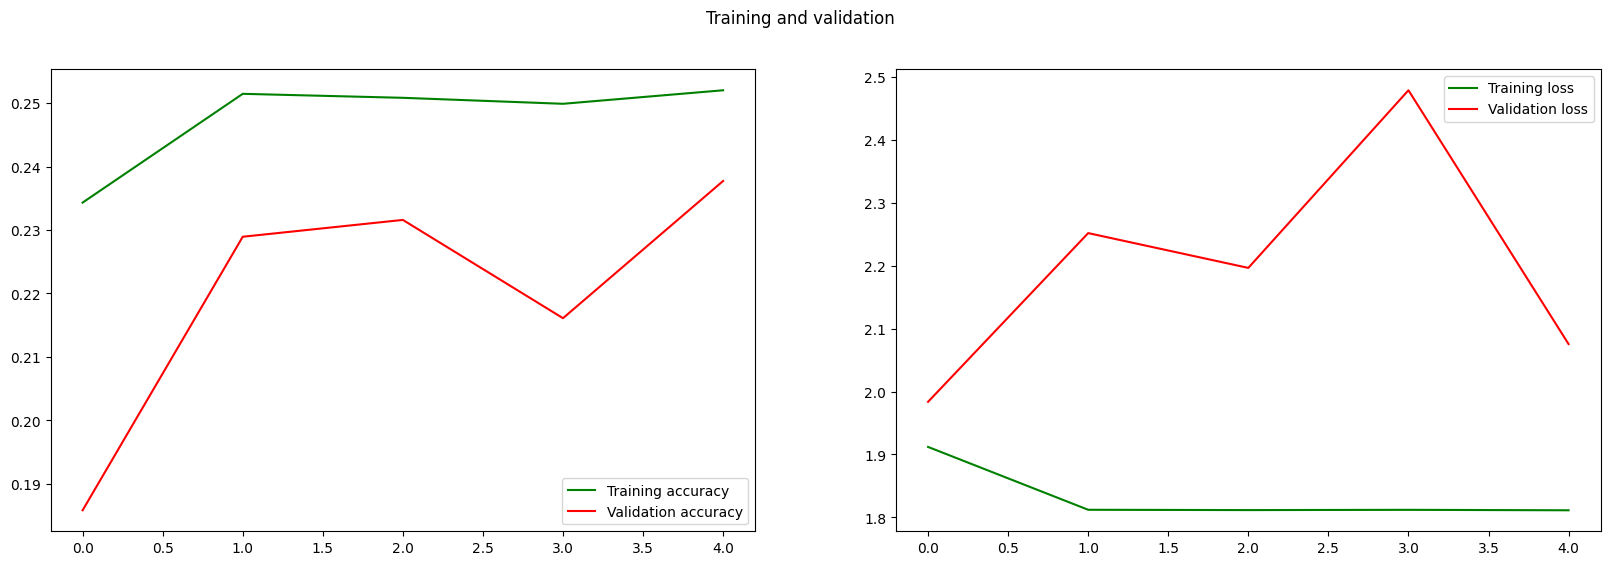

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))
ax[0].plot(epochs, acc, 'g', label='Training accuracy')
ax[0].plot(epochs, val_acc, 'r', label='Validation accuracy')
ax[0].legend(loc=0)
ax[1].plot(epochs, loss, 'g', label='Training loss')
ax[1].plot(epochs, val_loss, 'r', label='Validation loss')
ax[1].legend(loc=0)

plt.suptitle('Training and validation')
plt.show()

113/113 [==============================] - 18s 154ms/step
              precision    recall  f1-score   support

       angry       0.00      0.00      0.00       958
     disgust       0.00      0.00      0.00       111
        fear       0.20      0.02      0.04      1024
       happy       0.26      0.82      0.39      1774
     neutral       0.17      0.18      0.18      1233
         sad       0.21      0.00      0.00      1247
    surprise       0.12      0.00      0.00       831

    accuracy                           0.24      7178
   macro avg       0.14      0.15      0.09      7178
weighted avg       0.17      0.24      0.13      7178





/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


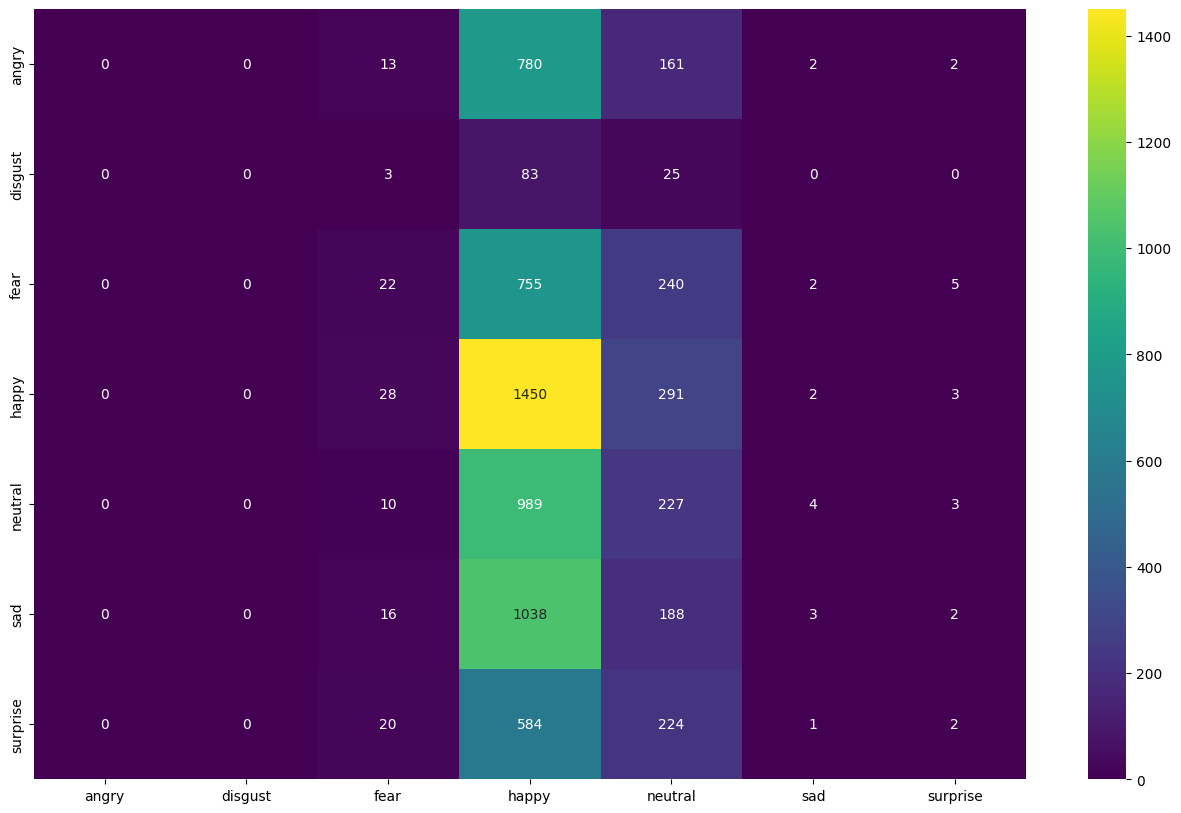

In [23]:
# confusion matrix
from sklearn.metrics import classification_report, confusion_matrix

y_pred = np.argmax(model.predict(test_generator), axis=-1)
print(classification_report(test_generator.classes, y_pred, target_names=test_generator.class_indices.keys()), end='\n\n\n')

cm = confusion_matrix(test_generator.classes, y_pred)
plt.figure(figsize=(16,10))
sns.heatmap(cm, cmap=plt.cm.viridis, annot=True, fmt='.0f', xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.show()

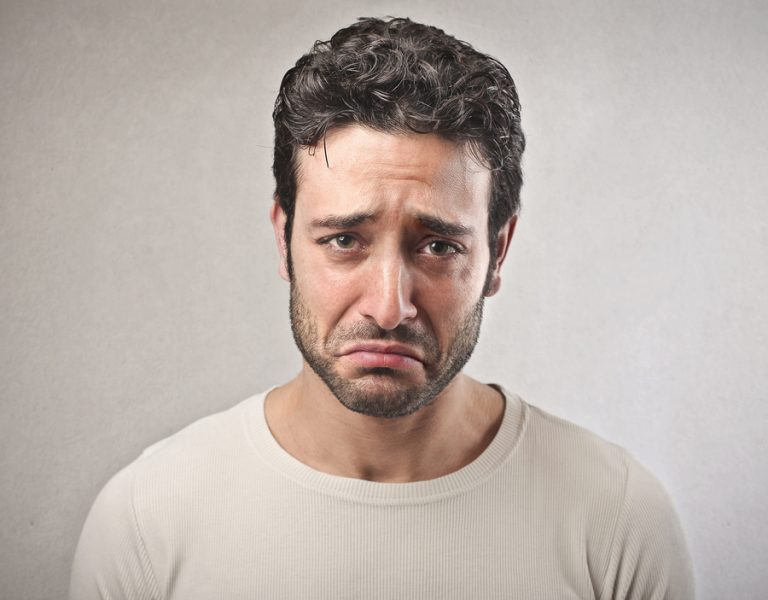

In [42]:
# Testing our model with new image
image = cv2.imread("/content/Sad_test.jpg")
from IPython.display import Image
Image(filename='/content/Sad_test.jpg')

In [38]:
import cv2
from tensorflow.python.keras.models import load_model
import os


# # load the trained model

model = tf.keras.models.load_model("model.h5",
    custom_objects={'Functional':tf.keras.models.Model})
# A list of emoticon categories
EMOTIONS = ['Angry', 'Disgust', 'Happy', 'Sad', 'Surprise', 'Neutral']
# Load image
img = image

# Trim the image to 48 x 48, and turn the grayscale image, normalization
frame = cv2.resize(img,(48,48),interpolation=cv2.INTER_BITS2)
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) / 255.0

# Reinvent the image dimension
gray = gray.reshape(1,48,48,1)

# Output the prediction
predicts = model.predict(gray)[0]
label = EMOTIONS[predicts.argmax()]
for (i,j) in zip(range(7),EMOTIONS):
    predictss = predicts[i]
    print("{:^10s}".format(j)+"prediction rate is   {0:.2f}%".format(predictss))
print( "\n\n The system considers this expression to be:",label)

1/1 [==============================] - 0s 173ms/step
  Angry   prediction rate is   0.00%
 Disgust  prediction rate is   0.00%
  Happy   prediction rate is   0.02%
   Sad    prediction rate is   0.90%
 Surprise prediction rate is   0.08%
 Neutral  prediction rate is   0.00%


 The system considers this expression to be: Sad


In [39]:
if (label=='Angry'):
    path="/content/Angry/"
    files=os.listdir(path)
    d=random.choice(files)
    print("Now Playing:",d)
    audio = Audio(filename='/content/Angry/'+ d,autoplay=True)
    display(audio)

elif (label=='Disgust'):
    path="/content/Disgust/"
    files=os.listdir(path)
    d=random.choice(files)
    print("Now Playing:",d)
    audio = Audio(filename='/content/Disgust/'+ d,autoplay=True)
    display(audio)

elif (label=="Happy"):
    path="/content/Happy/"
    files=os.listdir(path)
    d=random.choice(files)
    print("Now Playing:",d)
    audio = Audio(filename='/content/Happy/'+ d,autoplay=True)
    display(audio)

elif (label=='Sad'):
    path="/content/Sad/"
    files=os.listdir(path)
    d=random.choice(files)
    print("Now Playing:",d)
    audio = Audio(filename='/content/Sad/'+ d,autoplay=True)
    display(audio)

elif (label=='Surprise'):
    path="/content/Suprise/"
    files=os.listdir(path)
    d=random.choice(files)
    print("Now Playing:",d)
    audio = Audio(filename='/content/Suprise/'+ d,autoplay=True)
    display(audio)

elif (label=='Neutral'):
    path="/content/Neutral/"
    files=os.listdir(path)
    d=random.choice(files)
    print("Now Playing:",d)
    audio = Audio(filename='/content/Neutral/'+ d,autoplay=True)
    display(audio)

Now Playing: Mood Off ! Sad Mood Song.mp3
